# Decision Tree Learning: Prosper Loan Dataset

A decision tree a learned set of rules that allows us to make decisions on data.

We are going to look at the prosper loan dataset.  This dataset shows a history of loans made by Prosper.

In [24]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 executor.memory=2g
	some_property=some_value
	spark.app.name=TestApp
	spark.master=local[*]
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmp56a7a7mz
	spark.submit.deployMode=client
	spark.ui.showConsoleProgress=true
Spark UI running on port 4040


## Step 1: Load the Data

In [25]:
## small file, start with this
datafile = "/data/prosper-loan/prosper-loan-data-sample.csv"

## this is a large file
datafile = "/data/prosper-loan/prosper-loan-data.csv.gz"

In [26]:
%%time
data = spark.read. \
          option("header", "true"). \
          option("inferSchema", "true").  \
          csv(datafile)

CPU times: user 2.33 ms, sys: 1.81 ms, total: 4.14 ms
Wall time: 567 ms


In [27]:
print("read {:,} records".format(data.count()))
# schema
data.printSchema()

read 49,724 records
root
 |-- Term: integer (nullable = true)
 |-- LoanStatus: integer (nullable = true)
 |-- BorrowerRate: double (nullable = true)
 |-- ProsperRating (numeric): double (nullable = true)
 |-- ProsperScore: double (nullable = true)
 |-- ListingCategory: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- EmploymentStatus: string (nullable = true)
 |-- EmploymentStatusDuration: double (nullable = true)
 |-- IsBorrowerHomeowner: boolean (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- CurrentCreditLines: double (nullable = true)
 |-- OpenCreditLines: double (nullable = true)
 |-- TotalCreditLinespast7years: double (nullable = true)
 |-- OpenRevolvingAccounts: integer (nullable = true)
 |-- OpenRevolvingMonthlyPayment: double (nullable = true)
 |-- InquiriesLast6Months: double (nullable = true)
 |-- TotalInquiries: double (nullable = true)
 |-- CurrentDelinquencies: double (nullable = true)
 |-- AmountDelinquent: double (nullable = t

In [28]:
## print with pandas
data.limit(10).toPandas()

,Term,LoanStatus,BorrowerRate,ProsperRating (numeric),ProsperScore,ListingCategory,BorrowerState,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,...,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,YearsWithCredit
0,36,1,0.1580,4.0,6.0,Unknown,CO,Self-employed,2.0,True,...,0.0,0.0,0.00,9425,330.43,0,0,0.0,258,13
1,36,1,0.1325,4.0,6.0,Unknown,Unknown,Full-time,19.0,False,...,0.0,0.0,0.00,1000,33.81,0,0,0.0,53,14
2,36,0,0.1435,5.0,4.0,Debt,AL,Employed,1.0,False,...,0.0,0.0,0.00,4000,137.39,0,0,0.0,1,18
3,36,0,0.3177,1.0,5.0,Household,FL,Other,121.0,True,...,0.0,0.0,0.00,4000,173.71,0,0,0.0,10,15
4,36,1,0.2075,4.0,6.0,Unknown,MI,Full-time,36.0,False,...,0.0,0.0,0.00,3000,112.64,0,0,0.0,53,11
5,36,0,0.2419,3.0,5.0,Medical,IL,Employed,3.0,False,...,0.0,0.0,0.00,2000,78.67,0,0,0.0,30,16
6,60,1,0.2809,2.0,3.0,Debt,NY,Employed,25.0,False,...,0.0,0.0,0.00,4000,124.76,0,0,0.0,37,39
7,36,1,0.0920,6.0,9.0,Debt,CO,Full-time,10.0,True,...,0.0,0.0,0.00,4000,0.00,0,0,0.0,121,14
8,36,1,0.0999,6.0,9.0,Wedding,CA,Employed,44.0,False,...,0.0,0.0,0.00,10000,322.62,0,0,0.0,30,26
9,36,1,0.0785,7.0,10.0,Other,IL,Employed,7.0,False,...,0.0,4000.0,0.01,16000,500.28,0,0,0.0,326,11


In [29]:
## select a few columns 
## start with: 'LoanStatus',  'ProsperScore',  'EmploymentStatus', 'CreditScore', 'StatedMonthlyIncome'
## we can add more later

select_columns = ['LoanStatus', 'ProsperScore', 'EmploymentStatus', 'CreditScore', 'StatedMonthlyIncome']

## Note : vector columns can only have Numbers, don't include Categorical columns here
## And dfefinitely not 'LoanStatus'  (if you are curiuos include and see what happens!)
vector_columns = [ 'ProsperScore', 'EmpIndex', 'CreditScore', 'StatedMonthlyIncome']



In [30]:
## TODO : Extract only the columns we are interested in

prosper = data.select(select_columns)            
print (prosper.count())
prosper.limit(10).toPandas()

49724


,LoanStatus,ProsperScore,EmploymentStatus,CreditScore,StatedMonthlyIncome
0,1,6.0,Self-employed,640.0,3083.333333
1,1,6.0,Full-time,640.0,1666.666667
2,0,4.0,Employed,680.0,2416.666667
3,0,5.0,Other,700.0,5500.000000
4,1,6.0,Full-time,620.0,3750.000000
5,0,5.0,Employed,680.0,2500.000000
6,1,3.0,Employed,660.0,3885.916667
7,1,9.0,Full-time,700.0,6666.666667
8,1,9.0,Employed,740.0,3750.000000
9,1,10.0,Employed,760.0,13083.333333


## Step 2 : Clean Data

In [31]:
# Drop any NA values.  Using `dataframe.na.drop()`
prosper_clean = prosper.na.drop()
print("Original record count {:,}, cleaned records count {:,},  dropped {:,}"\
      .format(prosper.count(), prosper_clean.count(), (prosper.count() - prosper_clean.count())))
prosper_clean.show()


Original record count 49,724, cleaned records count 49,724,  dropped 0
+----------+------------+----------------+-----------+-------------------+
|LoanStatus|ProsperScore|EmploymentStatus|CreditScore|StatedMonthlyIncome|
+----------+------------+----------------+-----------+-------------------+
|         1|         6.0|   Self-employed|      640.0|        3083.333333|
|         1|         6.0|       Full-time|      640.0|        1666.666667|
|         0|         4.0|        Employed|      680.0|        2416.666667|
|         0|         5.0|           Other|      700.0|             5500.0|
|         1|         6.0|       Full-time|      620.0|             3750.0|
|         0|         5.0|        Employed|      680.0|             2500.0|
|         1|         3.0|        Employed|      660.0|        3885.916667|
|         1|         9.0|       Full-time|      700.0|        6666.666667|
|         1|         9.0|        Employed|      740.0|             3750.0|
|         1|        10.0|    

## Look at some summary data

**=> What does that say about the cardinality of these categorical columns?**


In [32]:
prosper_clean.describe().toPandas()

,summary,LoanStatus,ProsperScore,EmploymentStatus,CreditScore,StatedMonthlyIncome
0,count,49724,49724,49724,49724,49724
1,mean,0.6743222588689567,6.098905960904191,None,682.7121711849409,5122.985416164442
2,stddev,0.46863222975630386,1.759049111196807,None,66.71327750915779,5695.264677891696
3,min,0,1.0,Employed,520.0,0.0
4,max,1,11.0,Self-employed,880.0,618547.833333


In [33]:
prosper_clean.groupBy('LoanStatus').count().show()
prosper_clean.groupBy('EmploymentStatus').count().show()
# prosper_clean.groupBy('ListingCategory').count().show(60)
# print ("Listing cardniality : ", prosper_clean.select ("ListingCategory").distinct().count())

+----------+-----+
|LoanStatus|count|
+----------+-----+
|         1|33530|
|         0|16194|
+----------+-----+

+----------------+-----+
|EmploymentStatus|count|
+----------------+-----+
|        Employed|18393|
|       Part-time| 1060|
|   Self-employed| 3045|
|    Not employed|  583|
|           Other|  924|
|       Full-time|25016|
|         Retired|  703|
+----------------+-----+



## Step 3: Converting Categorical columns 

Convert categorical columns to numeric.   
Here let's convert **EmploymentStatus** column

In [34]:
from pyspark.ml.feature import StringIndexer

strIndexer_employment = StringIndexer(inputCol="EmploymentStatus", outputCol="EmpIndex")
prosper_indexed = strIndexer_employment.fit(prosper_clean).transform(prosper_clean)
prosper_indexed.limit(10).toPandas()

,LoanStatus,ProsperScore,EmploymentStatus,CreditScore,StatedMonthlyIncome,EmpIndex
0,1,6.0,Self-employed,640.0,3083.333333,2.0
1,1,6.0,Full-time,640.0,1666.666667,0.0
2,0,4.0,Employed,680.0,2416.666667,1.0
3,0,5.0,Other,700.0,5500.000000,4.0
4,1,6.0,Full-time,620.0,3750.000000,0.0
5,0,5.0,Employed,680.0,2500.000000,1.0
6,1,3.0,Employed,660.0,3885.916667,1.0
7,1,9.0,Full-time,700.0,6666.666667,0.0
8,1,9.0,Employed,740.0,3750.000000,1.0
9,1,10.0,Employed,760.0,13083.333333,1.0


## Step 4: Build feature vectors using VectorAssembler.

In [35]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")
feature_vector = assembler.transform(prosper_indexed)
feature_vector = feature_vector.withColumn("label", feature_vector["LoanStatus"])

feature_vector.limit(10).toPandas()

,LoanStatus,ProsperScore,EmploymentStatus,CreditScore,StatedMonthlyIncome,EmpIndex,features,label
0,1,6.0,Self-employed,640.0,3083.333333,2.0,"[6.0, 2.0, 640.0, 3083.333333]",1
1,1,6.0,Full-time,640.0,1666.666667,0.0,"[6.0, 0.0, 640.0, 1666.666667]",1
2,0,4.0,Employed,680.0,2416.666667,1.0,"[4.0, 1.0, 680.0, 2416.666667]",0
3,0,5.0,Other,700.0,5500.000000,4.0,"[5.0, 4.0, 700.0, 5500.0]",0
4,1,6.0,Full-time,620.0,3750.000000,0.0,"[6.0, 0.0, 620.0, 3750.0]",1
5,0,5.0,Employed,680.0,2500.000000,1.0,"[5.0, 1.0, 680.0, 2500.0]",0
6,1,3.0,Employed,660.0,3885.916667,1.0,"[3.0, 1.0, 660.0, 3885.916667]",1
7,1,9.0,Full-time,700.0,6666.666667,0.0,"[9.0, 0.0, 700.0, 6666.666667]",1
8,1,9.0,Employed,740.0,3750.000000,1.0,"[9.0, 1.0, 740.0, 3750.0]",1
9,1,10.0,Employed,760.0,13083.333333,1.0,"[10.0, 1.0, 760.0, 13083.333333]",1


## Step 5: Split Data into training and test.

We will split our the data up into training and test.  (You know the drill by now).

**=> TODO: Split dataset into 70% training, 30% validation**


In [36]:

# Split the data into training and test sets (30% held out for testing)
(training, test) =  feature_vector.randomSplit([.7,.3])
print("training set = " , training.count())
print("testing set = " , test.count())

training set =  34812
testing set =  14912


## Step 6: Decision Tree

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=5000)


In [38]:
%%time
print ("training starting...")
tree_model = dt.fit(training)
print ("training done")

training starting...
training done
CPU times: user 12.6 ms, sys: 4.01 ms, total: 16.6 ms
Wall time: 3.08 s


In [39]:
# print the model
print(tree_model)
print()
print(tree_model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_440a9fd2cf612f88e786) of depth 5 with 63 nodes

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_440a9fd2cf612f88e786) of depth 5 with 63 nodes
  If (feature 0 <= 7.5)
   If (feature 2 <= 710.0)
    If (feature 2 <= 610.0)
     If (feature 2 <= 530.0)
      If (feature 3 <= 7176.708333500001)
       Predict: 0.0
      Else (feature 3 > 7176.708333500001)
       Predict: 1.0
     Else (feature 2 > 530.0)
      If (feature 0 <= 3.5)
       Predict: 0.0
      Else (feature 0 > 3.5)
       Predict: 1.0
    Else (feature 2 > 610.0)
     If (feature 1 in {1.0,2.0,3.0,4.0,5.0,6.0})
      If (feature 3 <= 5202.0)
       Predict: 1.0
      Else (feature 3 > 5202.0)
       Predict: 1.0
     Else (feature 1 not in {1.0,2.0,3.0,4.0,5.0,6.0})
      If (feature 2 <= 650.0)
       Predict: 1.0
      Else (feature 2 > 650.0)
       Predict: 1.0
   Else (feature 2 > 710.0)
    If (feature 1 in {1.0,2.0,3.0,4.0,5.0,6.0})
     If (fea

** Q : How many nodes the tree has? **

In [40]:
predictions_test = tree_model.transform(test)

predictions2= predictions_test.drop('rawPrediction', 'probability')
# predictions2.show()

predictions2.limit(10).toPandas()


,LoanStatus,ProsperScore,EmploymentStatus,CreditScore,StatedMonthlyIncome,EmpIndex,features,label,prediction
0,0,1.0,Employed,600.0,3133.333333,1.0,"[1.0, 1.0, 600.0, 3133.333333]",0,0.0
1,0,1.0,Employed,600.0,3750.000000,1.0,"[1.0, 1.0, 600.0, 3750.0]",0,0.0
2,0,1.0,Employed,600.0,4666.666667,1.0,"[1.0, 1.0, 600.0, 4666.666667]",0,0.0
3,0,1.0,Employed,600.0,4666.666667,1.0,"[1.0, 1.0, 600.0, 4666.666667]",0,0.0
4,0,1.0,Employed,600.0,7083.333333,1.0,"[1.0, 1.0, 600.0, 7083.333333]",0,0.0
5,0,1.0,Employed,600.0,10708.333333,1.0,"[1.0, 1.0, 600.0, 10708.333333]",0,0.0
6,0,1.0,Employed,600.0,12083.333333,1.0,"[1.0, 1.0, 600.0, 12083.333333]",0,0.0
7,0,1.0,Employed,620.0,2500.000000,1.0,"[1.0, 1.0, 620.0, 2500.0]",0,1.0
8,0,1.0,Employed,620.0,3750.000000,1.0,"[1.0, 1.0, 620.0, 3750.0]",0,1.0
9,0,1.0,Employed,620.0,4750.000000,1.0,"[1.0, 1.0, 620.0, 4750.0]",0,1.0


## Step 7: Evaluate the model.

Let us check to see how the model did, using accuracy as a measure.

In [41]:
predictions_test = tree_model.transform(test)
predictions_train = tree_model.transform(training)

### 7.1 Model Accuracy

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.6796506951625876
Test set accuracy =  0.6789833690987125


### 7.2 Confusion Matrix

In [43]:
cm = predictions_test.groupBy('LoanStatus').pivot('prediction', [0,1]).count().na.fill(0).orderBy('LoanStatus')
cm.show()

+----------+---+----+
|LoanStatus|  0|   1|
+----------+---+----+
|         0|367|4502|
|         1|285|9758|
+----------+---+----+



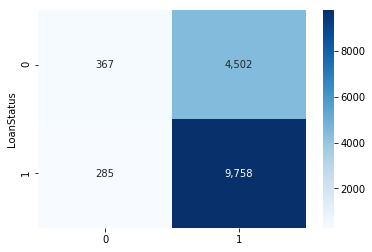

In [44]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("LoanStatus", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, fmt=',', cmap="Blues")

### 7.3 - AUC

For scewed data 'Area Under Precision Recall' curve might be better indicator.  
https://stats.stackexchange.com/questions/90779/area-under-the-roc-curve-or-area-under-the-pr-curve-for-imbalanced-data

In [45]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# default metrics for BinaryClassificationEvaluator is 'areaUnderCurve'
evaluator1 = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName='areaUnderROC')

print("AUC for training: " , evaluator1.evaluate(predictions_train))
print ("AUC for test : " , evaluator1.evaluate(predictions_test))

evaluator2 = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName='areaUnderPR')
print("Area under PR for training: " , evaluator2.evaluate(predictions_train))
print ("Area under PR for test : " , evaluator2.evaluate(predictions_test))


AUC for training:  0.43182375370678494
AUC for test :  0.43884364597194064
Area under PR for training:  0.6265219159618378
Area under PR for test :  0.6304403767073685


## Step 8: Improve Accuracy

### Add more data
In Step-1 change the 'datafile' to the full dataset.  
And see how the accuracy above changes

### Add more features
Look at the schema of the full dataset.  Are there any columns you want to add